In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18]
# branch_defs = [((0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18), 0.40540540540540543, 1), ((0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16), 0.3733733733733734, 0.40540540540540543), ((0, 2, 3, 4, 5, 6, 8, 9, 10, 14, 15, 16), 0.3663663663663664, 0.3733733733733734), ((0, 2, 3, 4, 5, 6, 8, 10, 14, 15), 0.34734734734734735, 0.3663663663663664), ((0, 2, 3, 4, 5, 6, 8, 10, 14), 0.33733733733733734, 0.34734734734734735), ((0, 2, 3, 4, 5, 6, 8, 10), 0.3313313313313313, 0.33733733733733734), ((9, 16), 0.3033033033033033, 0.3663663663663664), ((0, 2, 3, 4, 5, 8, 10), 0.2962962962962963, 0.3313313313313313), ((0, 2, 4), 0.26226226226226224, 0.2962962962962963), ((2, 4), 0.20520520520520522, 0.26226226226226224), ((3, 5, 8, 10), 0.15615615615615616, 0.2962962962962963), ((3, 5, 8), 0.14114114114114115, 0.15615615615615616), ((3, 8), 0.0, 0.14114114114114115), ((18,), 0, 0.40540540540540543), ((12,), 0, 0.3733733733733734), ((15,), 0, 0.34734734734734735), ((14,), 0, 0.33733733733733734), ((6,), 0, 0.3313313313313313), ((16,), 0, 0.3033033033033033), ((9,), 0, 0.3033033033033033), ((0,), 0, 0.26226226226226224), ((2,), 0, 0.20520520520520522), ((4,), 0, 0.20520520520520522), ((10,), 0, 0.15615615615615616), ((5,), 0, 0.14114114114114115), ((8,), 0, 0.0), ((3,), 0, 0.0)]
branch_defs = [((0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18), 0, 1)]

In [4]:
dataset = scrna_dataset.SingleCellDataset(
    "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/covid_flu_processed.h5"
)

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [14]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 5, input_shape)

t_limit = 1
model = scrna_ae.MultitaskAutoencoder(
    len(branch_defs), input_shape[0], t_limit=t_limit,
    enc_dims=[256, 128, 32], dec_dims=[256, 128], dropout=0
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/misc"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

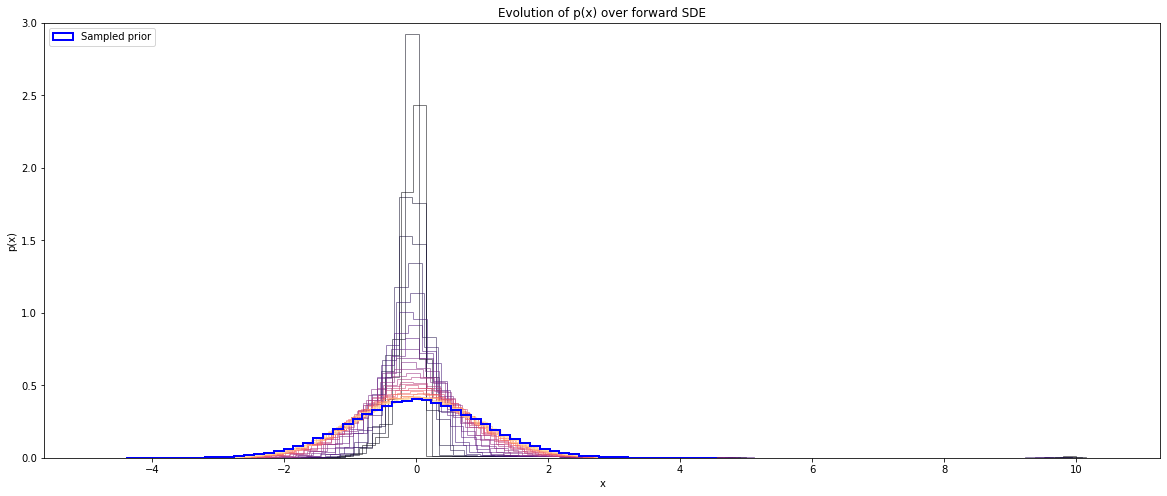

In [9]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [17]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 300,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "63"
Loss: 1000.12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.81it/s]


Epoch 1 average Loss: 1000.26


Loss: 1000.15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.82it/s]


Epoch 2 average Loss: 1000.18


Loss: 1000.12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.86it/s]


Epoch 3 average Loss: 1000.13


Loss: 1000.09: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.84it/s]


Epoch 4 average Loss: 1000.09


Loss: 1000.07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.83it/s]


Epoch 5 average Loss: 1000.07


Loss: 1000.09: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.87it/s]


Epoch 6 average Loss: 1000.04


Loss: 1000.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.81it/s]


Epoch 7 average Loss: 1000.03


Loss: 1000.05: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.82it/s]


Epoch 8 average Loss: 1000.02


Loss: 999.99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.84it/s]


Epoch 9 average Loss: 1000.01


Loss: 999.95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.82it/s]


Epoch 10 average Loss: 1000.00


Loss: 1000.05: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.82it/s]


Epoch 11 average Loss: 999.99


Loss: 1000.01: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.82it/s]


Epoch 12 average Loss: 999.98


Loss: 999.90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.77it/s]


Epoch 13 average Loss: 999.95


Loss: 999.93: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.83it/s]


Epoch 14 average Loss: 999.93


Loss: 999.86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:11<00:00, 19.81it/s]


Epoch 15 average Loss: 999.92


Loss: 999.82:  89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 203/229 [00:10<00:01, 19.69it/s]
WARNING - train - Aborted after 0:03:06!

KeyboardInterrupt



### Show generated distributions

In [ ]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit
    ).cpu().numpy()
    samples[class_to_sample] = sample

In [ ]:
# For simplicity, sample a lot of inputs for the real data
data, targets = [], []
for _ in range(len(classes)):
    x, y = next(iter(data_loader))
    data.append(x.cpu().numpy())
    targets.append(y.cpu().numpy())
data = np.concatenate([data])
targets = np.concatenate([targets])

for class_to_sample in classes:
    print("Class %s" % class_to_sample)
    real = data[targets == class_to_sample]
    sample = samples[class_to_sample]
    
    # Decide which features to plot
    num_features = min(input_shape[0], 16)
    feature_inds = np.flip(np.argsort(np.std(real, axis=0)))[:num_features]
    
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    # Plot feature values
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, f_i]
        sample_vals = sample[:, f_i]
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    plt.show()

    # Compute and plot correlations
    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i, f_i in enumerate(feature_inds):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            f_j = feature_inds[j]
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, f_i], real[:, f_j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, f_i], sample[:, f_j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()

In [ ]:
# # Plot the distribution of features by class
# num_features = input_shape[0]
# num_cols = 4
# num_rows = int(np.ceil(num_features / num_cols))
# num_bins = 20
# fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))

# for i in range(num_features):
#     r, c = i // num_cols, i % num_cols
#     data_to_plot = {}
#     for class_to_sample in classes:
#         data_to_plot[class_to_sample] = data[targets == class_to_sample][:, i]
#     all_vals = np.concatenate(list(data_to_plot.values()))
#     bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
#     for class_to_sample in classes:
#         ax[r][c].hist(
#             data_to_plot[class_to_sample], bins=bins, label=class_to_letter[class_to_sample],
#             density=True, alpha=0.5
#         )
#     ax[r][c].set_title("Feature %d" % (i + 1))
# ax[0][0].legend()
# plt.show()

**Diffusing from one class to another**

In [ ]:
# branch_time = 0.35
# c1, c2 = "V", "Y"

# num_features = input_shape[0]

# orig_c1 = torch.stack([
#     dataset[i][0].to(DEVICE) for i in 
#     np.random.choice(np.where(dataset.targets == letter_to_class[c1])[0], size=512, replace=False)
# ])
# orig_c2 = torch.stack([
#     dataset[i][0].to(DEVICE) for i in 
#     np.random.choice(np.where(dataset.targets == letter_to_class[c2])[0], size=512, replace=False)
# ])

# time_steps = 10
# all_t = np.linspace(0, branch_time, time_steps)
# forward_c1_to_c2 = np.empty((len(all_t),) + orig_c1.shape)
# backward_c1_to_c2 = np.empty((len(all_t) - 1,) + orig_c1.shape)
# forward_c2_to_c1 = np.empty((len(all_t),) + orig_c2.shape)
# backward_c2_to_c1 = np.empty((len(all_t) - 1,) + orig_c2.shape)
# for t_i, t in enumerate(all_t):
#     forward_c1_to_c2[t_i] = sde.forward(
#         orig_c1, torch.ones(len(orig_c1)).to(DEVICE) * t
#     )[0].cpu().numpy()
#     forward_c2_to_c1[t_i] = sde.forward(
#         orig_c2, torch.ones(len(orig_c2)).to(DEVICE) * t
#     )[0].cpu().numpy()

# all_t_flip = np.flip(all_t)
# last_c1_to_c2 = torch.tensor(forward_c1_to_c2[-1]).to(DEVICE).float()
# last_c2_to_c1 = torch.tensor(forward_c2_to_c1[-1]).to(DEVICE).float()
# for t_i in range(len(all_t_flip) - 1):
#     last_c1_to_c2 = generate.generate_continuous_branched_samples(
#         model, sde, letter_to_class[c2], class_time_to_branch_tensor, sampler="pc",
#         t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
#         num_samples=orig_c1.shape[0], initial_samples=last_c1_to_c2,
#         num_steps=50
#     )
#     backward_c1_to_c2[t_i] = last_c1_to_c2.cpu().numpy()
    
#     last_c2_to_c1 = generate.generate_continuous_branched_samples(
#         model, sde, letter_to_class[c1], class_time_to_branch_tensor, sampler="pc",
#         t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
#         num_samples=orig_c2.shape[0], initial_samples=last_c2_to_c1,
#         num_steps=50
#     )
#     backward_c2_to_c1[t_i] = last_c2_to_c1.cpu().numpy()
    
# # Compute correlation of features before and after transmutation
# c1_to_c2_corrs, c2_to_c1_corrs = np.empty(num_features), np.empty(num_features)
# for i in range(num_features):
#     c1_to_c2_corrs[i] = scipy.stats.pearsonr(
#         forward_c1_to_c2[0][:, i], backward_c1_to_c2[-1][:, i]
#     )[0]
#     c2_to_c1_corrs[i] = scipy.stats.pearsonr(
#         forward_c2_to_c1[0][:, i], backward_c2_to_c1[-1][:, i]
#     )[0]
    
# # Plot distribution trajectory in transmutation
# fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))
# forward_cmap = plt.get_cmap("Reds_r")
# backward_cmap = plt.get_cmap("Blues")
# for t_i in range(len(all_t)):
#     ax[0].hist(
#         np.ravel(forward_c1_to_c2[t_i]), bins=60, histtype="step", color=forward_cmap(t_i / len(all_t)),
#         alpha=0.5, density=True
#     )
#     ax[1].hist(
#         np.ravel(forward_c2_to_c1[t_i]), bins=60, histtype="step", color=forward_cmap(t_i / len(all_t)),
#         alpha=0.5, density=True
#     )
# for t_i, t in enumerate(all_t_flip[1:]):
#     ax[0].hist(
#         np.ravel(backward_c1_to_c2[t_i]), bins=60, histtype="step", color=backward_cmap(t_i / len(all_t)),
#         alpha=0.5, density=True
#     )
#     ax[1].hist(
#         np.ravel(backward_c2_to_c1[t_i]), bins=60, histtype="step", color=backward_cmap(t_i / len(all_t)),
#         alpha=0.5, density=True
#     )
# ax[0].set_title("%s to %s" % (c1, c2))
# ax[1].set_title("%s to %s" % (c2, c1))
# ax[1].set_xlabel("x")
# ax[0].set_ylabel("p(x)")
# ax[1].set_ylabel("p(x)")
# ax[0].set_ylim((0, 3))
# plt.show()

# # Plot correlation of features before and after transmutation
# num_features = input_shape[0]
# num_cols = 4
# num_rows = int(np.ceil(num_features / num_cols))
# for class_1, class_2, forwards, backwards in [
#     (c1, c2, forward_c1_to_c2[0], backward_c1_to_c2[-1]),
#     (c2, c1, forward_c2_to_c1[0], backward_c2_to_c1[-1])
# ]:
#     fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
#     for i in range(num_features):
#         r, c = i // num_cols, i % num_cols
#         x, y = forwards[:, i], backwards[:, i]
#         corr = scipy.stats.pearsonr(x, y)[0]
#         ax[r][c].scatter(x, y, alpha=0.5)
#         ax[r][c].text(
#             0.01, 0.99, "%.4f" % corr,
#             ha="left", va="top", transform=ax[r][c].transAxes
#         )
#         ax[r][c].set_xlabel("Before forward diffusion")
#         ax[r][c].set_ylabel("After backward diffusion")
#         ax[r][c].set_title("Feature %d" % (i + 1))
#     fig.suptitle("%s to %s" % (class_1, class_2))
#     plt.show()